# OCR

Napisz program przekształacający obraz w tekst, przyjmując następujące założenia:
1. Na obrazie znajduje się tekst złożony z małych liter alfabetu łacińskiego oraz cyfr
2. Na obrazie występuje jeden typ i rozmiar czcionki
3. Weź pod uwagę czcionki szeryfowe i bezszeryfowe
4. W tekście występują znaki przestankowe: .,?!
5. Tekst składa się z wielu linii
6. Tekst może być obrócony (krzywo zeskanowany w całości)
7. Program powinien zwracać tekst wraz ze znakami białymi i znakami nowych linii
8. Program może raportować procent poprawnie rozpoznanych liter dla pre-definiowanych
obrazów testowych
9. Program powinien dodatkowo zliczać liczbę wystąpień każdej litery
10. Należy zastosować operację splotu i DFT albo inne metody (klasyfikacja)
11. Należy dokonać redukcji szumu na obrazie wejściowym
12.

Wygenerowano obraz z tekstem: images/text_clean.png
Wygenerowano obraz z tekstem: images/text_noisy.png


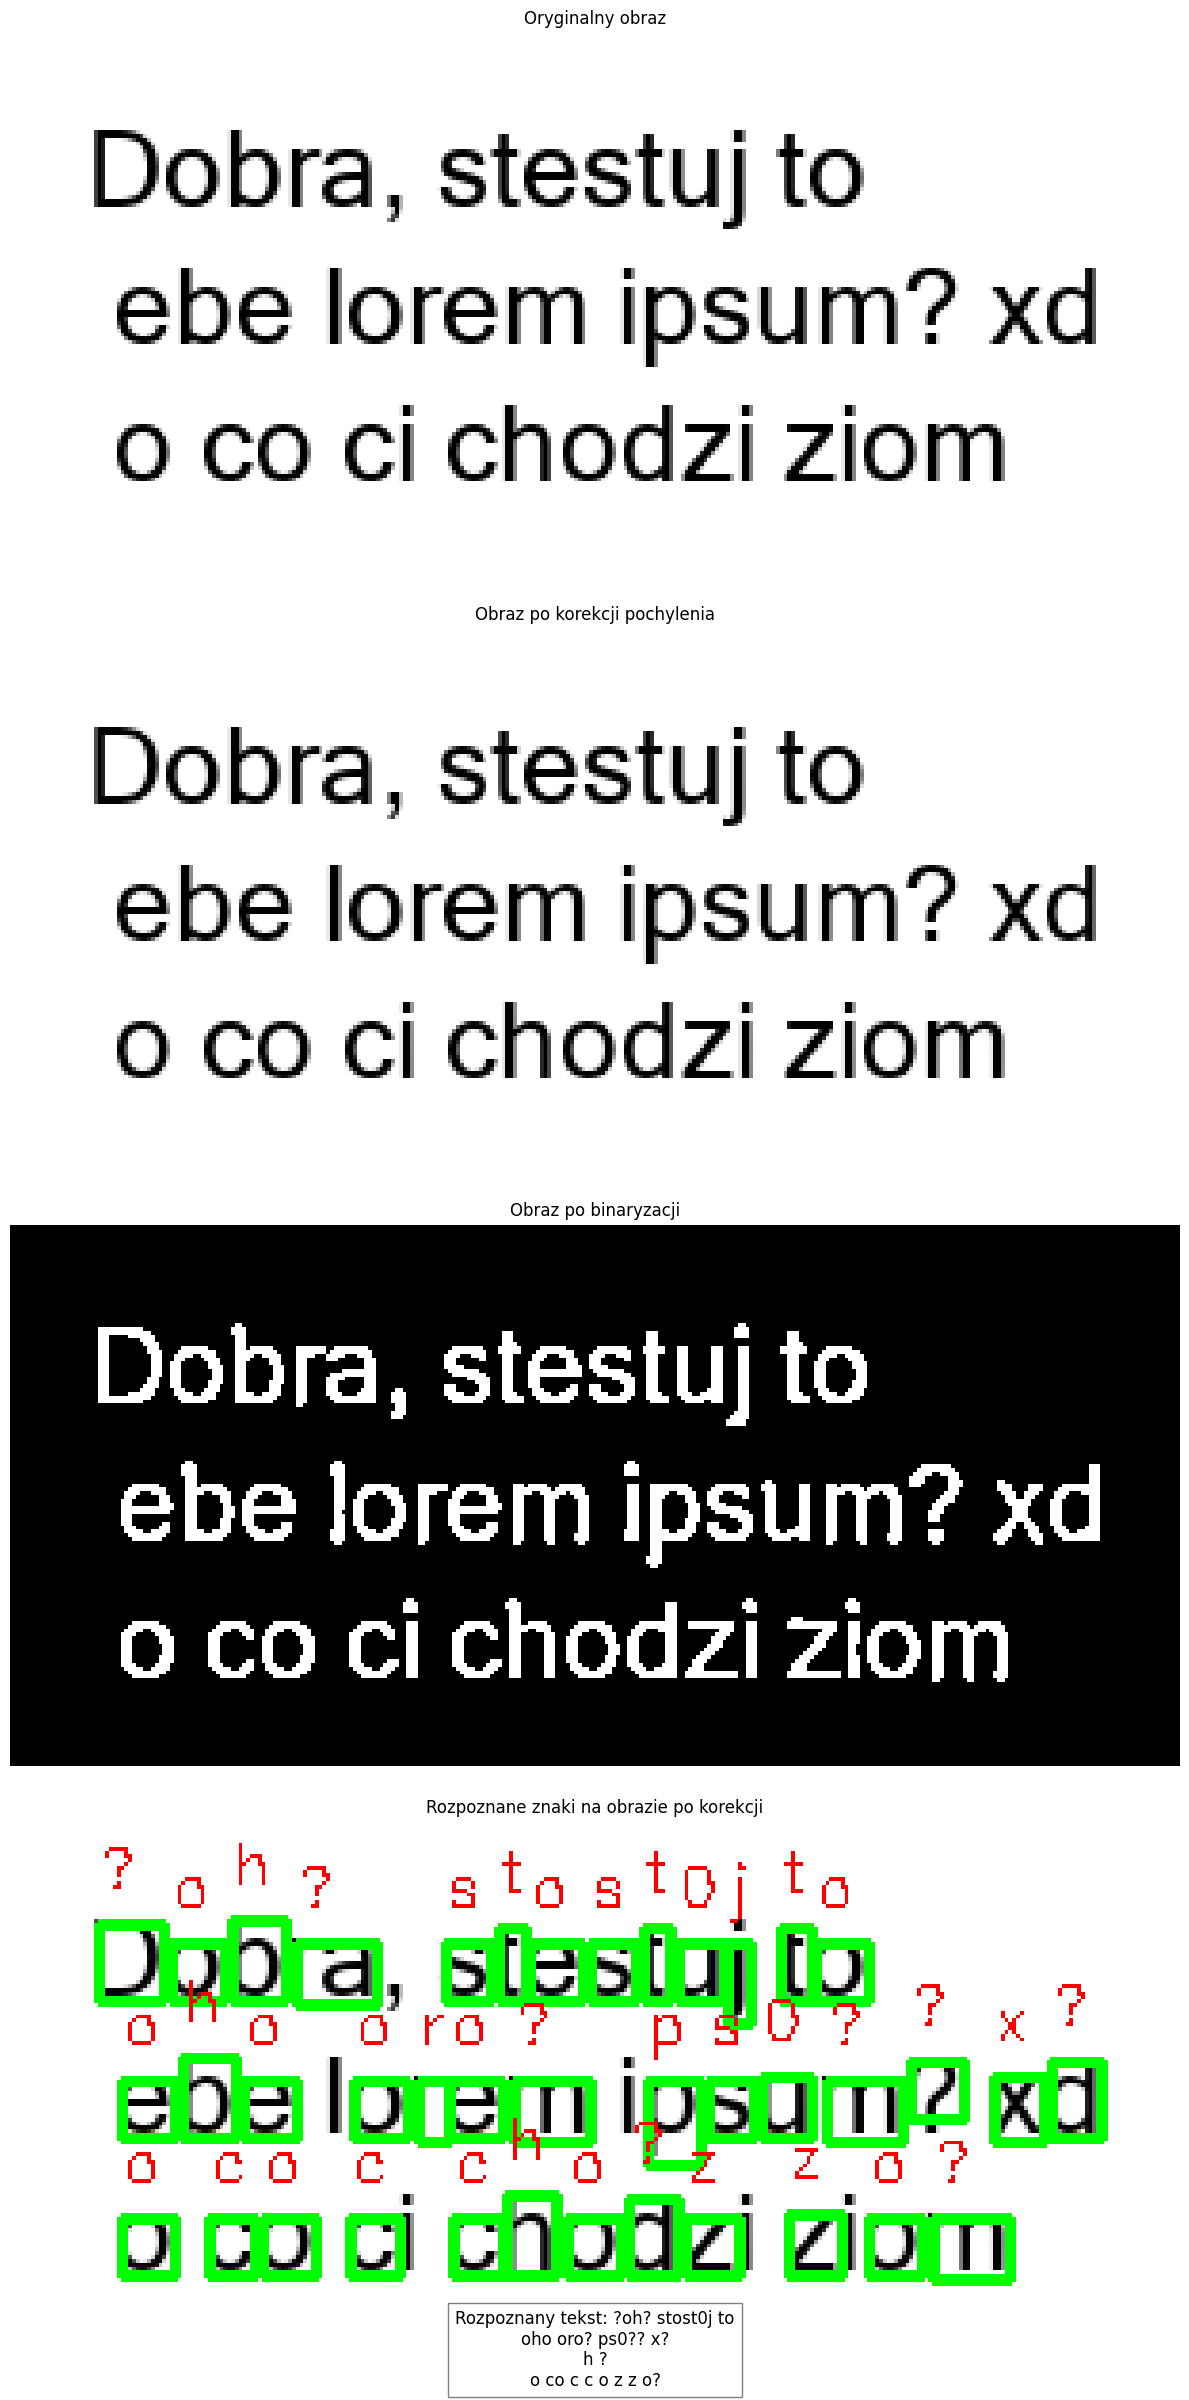

--- Wyniki Rozpoznawania ---
Rozpoznany tekst:
?oh? stost0j to
oho oro? ps0?? x?
h ?
o co c c o z z o?

--- Statystyki Znaków ---
{'?': 8, 'o': 11, 'h': 3, 's': 3, 't': 3, '0': 2, 'j': 1, 'r': 1, 'p': 1, 'x': 1, 'c': 3, 'z': 2}

Dokładność rozpoznawania: 14.55%


In [63]:
import numpy as np
import cv2
from PIL import Image, ImageFont, ImageDraw
import string
import matplotlib.pyplot as plt # Dodany import

class OCRProcessor:
    """
    Klasa do optycznego rozpoznawania znaków (OCR) z obrazu,
    wykorzystująca dopasowywanie wzorców, z opcją wizualizacji.
    """

    CHAR_SET = string.ascii_lowercase + string.digits + "?!.,"

    def __init__(self, font_paths: dict, font_size: int = 30):
        self.font_size = font_size
        self.templates = {}
        for style, path in font_paths.items():
            try:
                self.templates[style] = self._generate_char_templates(path)
            except IOError:
                print(f"Ostrzeżenie: Nie udało się wczytać czcionki ze ścieżki: {path}")

    def _generate_char_templates(self, font_path: str) -> dict:
        """Prywatna metoda do generowania obrazów wzorcowych dla każdego znaku."""
        templates = {}
        font = ImageFont.truetype(font_path, self.font_size)
        for char in self.CHAR_SET:
            try:
                bbox = font.getbbox(char)
                width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
                x_offset, y_offset = -bbox[0], -bbox[1]
            except AttributeError:
                 width, height = font.getsize(char)
                 x_offset, y_offset = 0, 0

            if width == 0 or height == 0: continue

            template_img = Image.new('L', (width, height), color=0)
            draw = ImageDraw.Draw(template_img)
            draw.text((x_offset, y_offset), char, font=font, fill=255)
            templates[char] = np.array(template_img)
        return templates

    def _detect_and_correct_skew(self, image: np.ndarray, max_angle: int = 30) -> np.ndarray:
        """
        Wykrywa i koryguje pochylenie tekstu na obrazie.

        :param image: Obraz w skali szarości
        :param max_angle: Maksymalny kąt pochylenia do sprawdzenia
        :return: Obraz po korekcji pochylenia
        """
        # Wykrywanie linii tekstu za pomocą transformaty Hougha
        edges = cv2.Canny(image, 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)

        # Obliczenie kąta pochylenia
        angles = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                if x2 - x1 != 0:  # unikanie dzielenia przez zero
                    angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
                    if abs(angle) < max_angle:  # filtrowanie zbyt dużych kątów
                        angles.append(angle)

        # Jeśli wykryto kąty pochylenia
        if angles:
            # Używamy mediany aby uniknąć wpływu wartości odstających
            skew_angle = np.median(angles)

            # Jeśli kąt jest wystarczająco duży, korygujemy
            if abs(skew_angle) > 0.5:
                h, w = image.shape[:2]
                center = (w // 2, h // 2)
                # Tworzymy macierz transformacji i obracamy obraz
                M = cv2.getRotationMatrix2D(center, skew_angle, 1.0)
                corrected = cv2.warpAffine(image, M, (w, h),
                                          flags=cv2.INTER_CUBIC,
                                          borderMode=cv2.BORDER_REPLICATE)
                return corrected

        return image  # Zwracamy oryginalny obraz, jeśli nie wykryto pochylenia


    def _preprocess_image(self, image_path: str) -> np.ndarray:
        """
        Wczytuje obraz, poprawia kontrast, koryguje pochylenie,
        redukuje szum i wykonuje zaawansowaną binaryzację adaptacyjną.

        :param image_path: Ścieżka do pliku obrazu
        :return: Obraz binarny przygotowany do OCR
        """
        # Wczytanie obrazu w skali szarości
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise FileNotFoundError(f"Nie można wczytać obrazu ze ścieżki: {image_path}")

        # Poprawa kontrastu za pomocą CLAHE (nadal bardzo przydatne)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        contrast_img = clahe.apply(image)

        # Korekcja pochylenia tekstu
        corrected_image = self._detect_and_correct_skew(contrast_img)

        # Delikatne rozmycie Gaussowskie zamiast medianowego, często lepiej
        # współpracuje z adaptacyjnym progiem.
        denoised_image = cv2.GaussianBlur(corrected_image, (3, 3), 0)

        # ZASTOSOWANIE ADAPTACYJNEJ BINARYZACJI ZAMIAST GLOBALNEJ
        # Ta metoda znacznie lepiej radzi sobie z nierównym oświetleniem
        binary_image = cv2.adaptiveThreshold(
            denoised_image,
            255,  # Maksymalna wartość piksela
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Metoda obliczania progu (ważona średnia Gaussa jest zwykle najlepsza)
            cv2.THRESH_BINARY_INV,  # Inwersja (biały tekst na czarnym tle)
            blockSize=15,  # Rozmiar sąsiedztwa do obliczenia progu (musi być nieparzysty)
            C=8  # Stała odejmowana od obliczonego progu. Pozwala na precyzyjne dostrojenie.
        )

        # DODATKOWY KROK: Oczyszczanie morfologiczne
        # Operacja otwarcia (erozja -> dylatacja) usuwa małe, pojedyncze
        # białe kropki (szum "pieprzu"), które mogły powstać podczas binaryzacji.
        kernel = np.ones((2, 2), np.uint8)
        binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=1)

        return binary_image

    def _segment_into_characters(self, binary_image: np.ndarray) -> list:
        """Segmentuje obraz na pojedyncze znaki używając cv2.findContours."""
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        character_regions = []
        for contour in contours:
            (x, y, w, h) = cv2.boundingRect(contour)
            min_height, min_width = 10, 5
            if w > min_width and h > min_height:
                roi = binary_image[y:y+h, x:x+w]
                character_regions.append(((x, y, w, h), roi))
        return character_regions

    def _match_and_recognize(self, roi: np.ndarray, font_style: str) -> str:
        """Rozpoznaje znak w danym regionie (ROI) przez dopasowanie do wzorców."""
        best_match = '?'
        highest_score = 0.3
        templates_to_use = self.templates.get(font_style)
        if not templates_to_use:
            raise ValueError(f"Nie znaleziono wzorców dla stylu czcionki: {font_style}")

        for char, template in templates_to_use.items():
            resized_roi = cv2.resize(roi, (template.shape[1], template.shape[0]))
            result = cv2.matchTemplate(resized_roi.astype(np.float32), template.astype(np.float32), cv2.TM_CCOEFF_NORMED)
            _, score, _, _ = cv2.minMaxLoc(result)
            if score > highest_score:
                highest_score = score
                best_match = char
        return best_match

    def _rebuild_text(self, recognized_characters: list) -> (str, dict):
        """Sortuje rozpoznane znaki i rekonstruuje z nich tekst."""
        if not recognized_characters: return "", {}

        line_height_tolerance = 20
        recognized_characters.sort(key=lambda item: (item[0][1] // line_height_tolerance, item[0][0]))

        text_buffer = []
        char_counter = {}
        if not recognized_characters: return "", {}

        avg_char_width = np.mean([char_box[2] for char_box, char in recognized_characters])

        for i, (char_box, char) in enumerate(recognized_characters):
            x, y, w, h = char_box
            if i > 0:
                prev_box, _ = recognized_characters[i-1]
                prev_y = prev_box[1]
                if (y // line_height_tolerance) > (prev_y // line_height_tolerance):
                    text_buffer.append('\n')
                else:
                    distance = x - (prev_box[0] + prev_box[2])
                    if distance > avg_char_width * 0.4:
                        text_buffer.append(' ')

            text_buffer.append(char)
            char_counter[char] = char_counter.get(char, 0) + 1

        return "".join(text_buffer), char_counter

    def visualize_recognition(self, original_image_path: str, recognized_characters: list, output_path: str = None):
        """
        Tworzy wizualizację procesu rozpoznawania, rysując ramki i etykiety na obrazie.
        """
        # Wczytaj oryginalny obraz w kolorze
        image_to_draw_on = cv2.imread(original_image_path)

        for box, char in recognized_characters:
            x, y, w, h = box
            # Rysuj zielony prostokąt wokół rozpoznanego znaku
            cv2.rectangle(image_to_draw_on, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # Dodaj czerwoną etykietę z rozpoznanym znakiem nad prostokątem
            cv2.putText(image_to_draw_on, char, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        if output_path:
            # Zapisz obraz do pliku
            cv2.imwrite(output_path, image_to_draw_on)
            print(f"Wizualizacja została zapisana do pliku: {output_path}")
        else:
            # Wyświetl obraz w oknie
            plt.figure(figsize=(16, 12))
            # Konwertuj z formatu BGR (OpenCV) na RGB (Matplotlib)
            plt.imshow(cv2.cvtColor(image_to_draw_on, cv2.COLOR_BGR2RGB))
            plt.title('Wizualizacja Rozpoznawania Znaków')
            plt.axis('off')
            plt.show()

    def process_image(self, image_path: str, font_style: str = 'sans-serif',
                     visualize: bool = False, output_viz_path: str = None,
                     jupyter_viz: bool = False) -> (str, dict):
        """
        Główna metoda publiczna - wykonuje pełny proces OCR na danym obrazie.

        :param image_path: Ścieżka do pliku obrazu.
        :param font_style: Styl czcionki do użycia przy rozpoznawaniu ('serif', 'sans-serif').
        :param visualize: Jeśli True, wygeneruje wizualizację rozpoznawania.
        :param output_viz_path: Ścieżka do zapisu pliku z wizualizacją.
        :param jupyter_viz: Jeśli True, wyświetli wizualizację w Jupyter Notebook.
        :return: Krotka zawierająca (rozpoznany_tekst, słownik_zliczeń_znaków).
        """
        binary_image = self._preprocess_image(image_path)
        character_regions = self._segment_into_characters(binary_image)

        recognized_chars = []
        for box, roi in character_regions:
            char = self._match_and_recognize(roi, font_style)
            recognized_chars.append((box, char))

        final_text, counts = self._rebuild_text(recognized_chars)

        # Standardowa wizualizacja do pliku/okna
        if visualize:
            self.visualize_recognition(image_path, recognized_chars, output_viz_path)

        # Wizualizacja dedykowana dla Jupyter Notebook
        if jupyter_viz:
            self.visualize_in_notebook(image_path, binary_image, recognized_chars, final_text)

        return final_text, counts


    def visualize_in_notebook(self, image_path: str, binary_image: np.ndarray, recognized_characters: list, text_result: str):
        """
        Tworzy wizualizację procesu OCR w Jupyter Notebook.
        Pokazuje obraz oryginalny, po korekcji pochylenia, po binaryzacji i z oznaczonymi rozpoznanymi znakami.

        :param image_path: Ścieżka do oryginalnego obrazu
        :param binary_image: Przetworzony obraz binarny
        :param recognized_characters: Lista krotek (bounding_box, rozpoznany_znak)
        :param text_result: Ostatecznie rozpoznany tekst
        """
        # Wczytaj oryginalny obraz
        original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Zastosuj poprawę kontrastu i korekcję pochylenia (taki sam proces jak w _preprocess_image)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        contrast_img = clahe.apply(original)
        corrected_image = self._detect_and_correct_skew(contrast_img)

        # Konwersja skorygowanego obrazu do RGB na potrzeby oznaczania
        corrected_color = cv2.cvtColor(corrected_image, cv2.COLOR_GRAY2RGB)

        # Przygotuj obraz z oznaczeniami na obrazie po korekcji pochylenia
        image_with_boxes = corrected_color.copy()

        for box, char in recognized_characters:
            x, y, w, h = box
            # Rysuj zielony prostokąt wokół rozpoznanego znaku
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # Dodaj czerwoną etykietę z rozpoznanym znakiem
            cv2.putText(image_with_boxes, char, (x, y - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # Utworzenie podwykresów w układzie pionowym (4 wiersze, 1 kolumna)
        fig, axes = plt.subplots(4, 1, figsize=(12, 24))

        # Oryginalny obraz
        axes[0].imshow(original, cmap='gray')
        axes[0].set_title("Oryginalny obraz")
        axes[0].axis('off')

        # Obraz po korekcji pochylenia
        axes[1].imshow(corrected_image, cmap='gray')
        axes[1].set_title("Obraz po korekcji pochylenia")
        axes[1].axis('off')

        # Obraz binarny
        axes[2].imshow(binary_image, cmap='gray')
        axes[2].set_title("Obraz po binaryzacji")
        axes[2].axis('off')

        # Obraz z oznaczonymi znakami na skorygowanym obrazie
        axes[3].imshow(image_with_boxes)
        axes[3].set_title("Rozpoznane znaki na obrazie po korekcji")
        axes[3].axis('off')

        plt.tight_layout()

        # Dodanie informacji o rozpoznanym tekście
        plt.figtext(0.5, 0, f"Rozpoznany tekst: {text_result}",
                    ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

        plt.show()

    @staticmethod
    def generate_text_image(text: str, output_path: str, font_path: str, font_size: int = 30,
                            bg_color: tuple = (255, 255, 255), text_color: tuple = (0, 0, 0),
                            rotation: float = 0, noise_level: float = 0, padding: int = 20):
        """
        Generuje obraz zawierający podany tekst z wybraną czcionką.

        :param text: Tekst do umieszczenia na obrazie
        :param output_path: Ścieżka do zapisu wygenerowanego obrazu
        :param font_path: Ścieżka do pliku czcionki (TTF)
        :param font_size: Rozmiar czcionki
        :param bg_color: Kolor tła jako (R,G,B)
        :param text_color: Kolor tekstu jako (R,G,B)
        :param rotation: Obrót tekstu w stopniach
        :param noise_level: Poziom szumu (0-1)
        :param padding: Odstęp od krawędzi obrazu
        """
        try:
            font = ImageFont.truetype(font_path, font_size)
        except IOError:
            raise ValueError(f"Nie można załadować czcionki z pliku: {font_path}")

        # Obliczanie rozmiaru obrazu na podstawie tekstu
        lines = text.split('\n')
        img_width = 0
        img_height = 0

        for line in lines:
            try:
                bbox = font.getbbox(line)
                line_width = bbox[2] - bbox[0]
                line_height = bbox[3] - bbox[1]
            except AttributeError:
                line_width, line_height = font.getsize(line)

            img_width = max(img_width, line_width)
            img_height += line_height + 10  # 10 pikseli odstępu między liniami

        # Dodanie paddingu do wymiarów obrazu
        img_width += 2 * padding
        img_height += 2 * padding

        # Tworzenie obrazu
        img = Image.new('RGB', (img_width, img_height), color=bg_color)
        draw = ImageDraw.Draw(img)

        # Rysowanie tekstu
        y_offset = padding
        for line in lines:
            try:
                bbox = font.getbbox(line)
                x_offset = padding - bbox[0]  # Uwzględnianie potencjalnego ujemnego x w bbox
            except AttributeError:
                x_offset = padding

            draw.text((x_offset, y_offset), line, font=font, fill=text_color)

            try:
                y_offset += font.getbbox(line)[3] - font.getbbox(line)[1] + 10
            except AttributeError:
                y_offset += font.getsize(line)[1] + 10

        # Zastosowanie obrotu tekstu jeśli potrzebne
        if rotation != 0:
            img = img.rotate(rotation, resample=Image.BICUBIC, expand=True, fillcolor=bg_color)

        # Dodanie szumu jeśli potrzebne
        if noise_level > 0:
            img_array = np.array(img)
            noise = np.random.rand(*img_array.shape) * 255 * noise_level
            noisy_img = np.clip(img_array + noise, 0, 255).astype(np.uint8)
            img = Image.fromarray(noisy_img)

        # Zapisanie obrazu
        img.save(output_path)
        print(f"Wygenerowano obraz z tekstem: {output_path}")

        # Zwróć też obraz, żeby można go było wyświetlić w notebooku
        return img

    @staticmethod
    def evaluate(recognized_text: str, ground_truth: str, ignore_case: bool = True) -> float:
        """
        Oblicza dokładność rozpoznawania tekstu porównując wynik OCR z tekstem referencyjnym.

        :param recognized_text: Tekst rozpoznany przez OCR
        :param ground_truth: Referencyjny tekst (poprawny)
        :param ignore_case: Czy ignorować wielkość liter przy porównaniu
        :return: Procentowa dokładność rozpoznawania (0-100)
        """
        if ignore_case:
            recognized_text = recognized_text.lower()
            ground_truth = ground_truth.lower()

        # Obliczanie odległości Levenshteina
        def levenshtein_distance(s1, s2):
            if len(s1) < len(s2):
                return levenshtein_distance(s2, s1)

            if len(s2) == 0:
                return len(s1)

            previous_row = range(len(s2) + 1)
            for i, c1 in enumerate(s1):
                current_row = [i + 1]
                for j, c2 in enumerate(s2):
                    insertions = previous_row[j + 1] + 1
                    deletions = current_row[j] + 1
                    substitutions = previous_row[j] + (c1 != c2)
                    current_row.append(min(insertions, deletions, substitutions))
                previous_row = current_row

            return previous_row[-1]

        # Obliczanie dokładności
        distance = levenshtein_distance(recognized_text, ground_truth)
        max_length = max(len(recognized_text), len(ground_truth))

        if max_length == 0:
            return 100.0  # Oba teksty są puste

        accuracy = (1 - distance / max_length) * 100
        return accuracy

# --- PRZYKŁAD UŻYCIA ---

if __name__ == '__main__':
    # Upewnij się, że masz pliki czcionek .ttf w odpowiednich ścieżkach
    try:
        font_definitions = {
            'sans-serif': 'fonts/sans-serif.ttf',
            'times': 'fonts/times-new-roman.ttf' # Times New Roman
        }

        font_path = 'fonts/sans-serif.ttf'
        text = "Dobra, stestuj to\n ebe lorem ipsum? xd\n o co ci chodzi ziom"

        # Generowanie czystego obrazu
        clean_img = OCRProcessor.generate_text_image(
            text=text,
            output_path="images/text_clean.png",
            font_path=font_path,
            font_size=28,
            rotation=0,
            noise_level=0
        )

        # Generowanie obrazu z szumem i rotacją
        noisy_img = OCRProcessor.generate_text_image(
            text=text,
            output_path="images/text_noisy.png",
            font_path=font_path,
            font_size=28,
            rotation=3,  # 3 stopnie rotacji
            noise_level=0.1  # 10% szumu
        )


        # Sprawdzenie OCR na wygenerowanych obrazach
        ocr = OCRProcessor(font_paths=font_definitions, font_size=28)

        recognized_text, char_counts = ocr.process_image(
            'images/text_clean.png',
            font_style='times',
            jupyter_viz=True
        )

        # 3. Wyświetlenie wyników
        print("--- Wyniki Rozpoznawania ---")
        print(f"Rozpoznany tekst:\n{recognized_text}\n")
        print("--- Statystyki Znaków ---")
        print(char_counts)

        # 4. Ewaluacja (jeśli znasz poprawny tekst)
        ground_truth_content = "przykladowy tekst do testow 123"
        accuracy = OCRProcessor.evaluate(recognized_text, ground_truth_content)
        print(f"\nDokładność rozpoznawania: {accuracy:.2f}%")

    except FileNotFoundError:
        print("Błąd: Nie znaleziono plików czcionek. Upewnij się, że 'arial.ttf' i 'times.ttf' znajdują się w katalogu.")
    except Exception as e:
        print(f"Wystąpił nieoczekiwany błąd: {e}")

